## Import Library

In [8]:
# https://towardsdatascience.com/abstractive-summarization-using-pytorch-f5063e67510
# https://towardsdatascience.com/top-nlp-libraries-to-use-2020-4f700cdb841f
from transformers import pipeline
import os

## Setting GPU and Model to Use

In [9]:
## Setting to use the 0th GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Setting to use the bart-large-cnn model for summarization
summarizer = pipeline("summarization")

## To use the t5-base model for summarization:
## summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [1]:
import pandas as pd

In [12]:
df = pd.read_csv('../data/Dataset.csv')

In [5]:
df.columns

Index(['Ref', 'Original text',
       'Abstractive summarization (extremely short version - will require longer version in practice)',
       'Extractive generalization (highlighting information that is company-specific)'],
      dtype='object')

In [2]:
#!pip3 install spacy
import spacy
nlp = spacy.load("en_core_web_sm")

/home/tur/.local/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Input the Text to Summarize

## Summarize

In [14]:
arr = []
for i in range(len(df)):
    try:
        txt = df.iloc[i][1]
        sm = summarizer(txt, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
        t1 = nlp(txt)
        t2 = nlp(sm)
        r = t1.similarity(t2)
        print(f'{i} out of {len(df)} returns {r:.3f}')
        arr.append(r)
    except Exception as e:
        print(e)

/tmp/ipykernel_227891/2100162076.py:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  r = t1.similarity(t2)


0 out of 47 returns 0.902
1 out of 47 returns 0.850
2 out of 47 returns 0.872
3 out of 47 returns 0.913
4 out of 47 returns 0.851
5 out of 47 returns 0.878
6 out of 47 returns 0.819
7 out of 47 returns 0.902
8 out of 47 returns 0.927
9 out of 47 returns 0.783
10 out of 47 returns 0.836
11 out of 47 returns 0.934
12 out of 47 returns 0.908
13 out of 47 returns 0.882
14 out of 47 returns 0.939
15 out of 47 returns 0.868
16 out of 47 returns 0.947
17 out of 47 returns 0.899
18 out of 47 returns 0.914
19 out of 47 returns 0.889
20 out of 47 returns 0.950
21 out of 47 returns 0.820
22 out of 47 returns 0.696
index out of range in self
24 out of 47 returns 0.902
25 out of 47 returns 0.897
index out of range in self
27 out of 47 returns 0.928
28 out of 47 returns 0.846
29 out of 47 returns 0.906
30 out of 47 returns 0.892
31 out of 47 returns 0.842
32 out of 47 returns 0.895
33 out of 47 returns 0.937
34 out of 47 returns 0.889
35 out of 47 returns 0.900
36 out of 47 returns 0.849


Your max_length is set to 100, but you input_length is only 92. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


37 out of 47 returns 0.868
38 out of 47 returns 0.926
39 out of 47 returns 0.853
40 out of 47 returns 0.959


Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


41 out of 47 returns 0.858


Your max_length is set to 100, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


42 out of 47 returns 0.876
43 out of 47 returns 0.949
44 out of 47 returns 0.920
45 out of 47 returns 0.867
46 out of 47 returns 0.885


In [2]:
#arr

In [3]:
#import seaborn as sns
#sns.set_theme(style="whitegrid")
#ax = sns.barplot(data=arr)

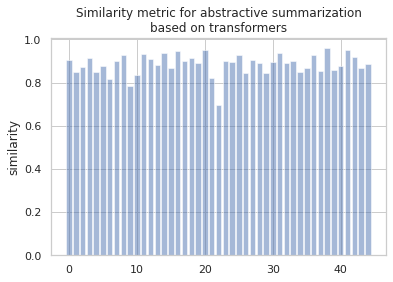

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.bar(np.arange(len(arr)), arr, align='center', alpha=0.5)
plt.title('Similarity metric for abstractive summarization\nbased on transformers')
plt.ylabel('similarity')
plt.show()

In [24]:
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest

In [26]:
def sm2(txt): 
    doc = nlp(re.sub(r'\n',' ',txt))
    keyword = []
    stopwords = list(STOP_WORDS)
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    for token in doc:
        if(token.text in stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keyword.append(token.text)
    freq_word = Counter(keyword)

    max_freq = Counter(keyword).most_common(1)[0][1]
    for word in freq_word.keys():  
        freq_word[word] = (freq_word[word]/max_freq)
    freq_word.most_common(5)

    sent_strength={}
    for sent in doc.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent]+=freq_word[word.text]
                else:
                    sent_strength[sent]=freq_word[word.text]

    summarized_sentences = nlargest(3, sent_strength, key=sent_strength.get)
    # summary
    final_sentences = [ w.text for w in summarized_sentences ]
    summary = ' '.join(final_sentences)
    return(summary)

In [31]:
import re
arr2 = []
for i in range(len(df)):
    try:
        txt = df.iloc[i][1]
        sm = sm2(txt)
        t1 = nlp(txt)
        t2 = nlp(sm)
        r = t1.similarity(t2)
        print(f'{i} out of {len(df)} returns {r:.3f}')
        arr2.append(r)
    except Exception as e:
        print(e)

/tmp/ipykernel_227891/2978185231.py:9: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  r = t1.similarity(t2)


0 out of 47 returns 0.957
1 out of 47 returns 0.985
2 out of 47 returns 0.923
3 out of 47 returns 0.962
4 out of 47 returns 0.959
5 out of 47 returns 0.979
6 out of 47 returns 0.944
7 out of 47 returns 0.972
8 out of 47 returns 0.939
9 out of 47 returns 0.980
10 out of 47 returns 0.973
11 out of 47 returns 0.970
12 out of 47 returns 0.945
13 out of 47 returns 0.992
14 out of 47 returns 0.993
15 out of 47 returns 0.959
16 out of 47 returns 0.989
17 out of 47 returns 0.964
18 out of 47 returns 0.983
19 out of 47 returns 0.967
20 out of 47 returns 1.000
21 out of 47 returns 0.956
22 out of 47 returns 0.998
23 out of 47 returns 0.938
24 out of 47 returns 0.977
25 out of 47 returns 0.975
26 out of 47 returns 0.946
27 out of 47 returns 0.964
28 out of 47 returns 0.952
29 out of 47 returns 0.964
30 out of 47 returns 0.939
31 out of 47 returns 0.974
32 out of 47 returns 0.983
33 out of 47 returns 0.990
34 out of 47 returns 0.974
35 out of 47 returns 0.961
36 out of 47 returns 0.973
37 out of 4

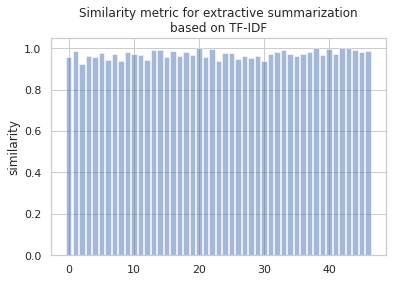

In [33]:
plt.bar(np.arange(len(arr2)), arr2, align='center', alpha=0.5)
plt.title('Similarity metric for extractive summarization\nbased on TF-IDF')
plt.ylabel('similarity')
plt.show()

In [34]:
# extractive generalisation

In [4]:
df2 = pd.read_csv('../data/generalisation.csv')

In [5]:
df2

,Original text,"""Abstractive summarization (extremely short version - will require longer version in practice)""","""Extractive generalization (information that is company-specific)"""
0,The Group competes in the gifting market (the ...,The Group faces significant competition for it...,The Group faces significant competition from a...
1,The Group’s success depends on its ability to ...,The Group’s efforts to retain existing custome...,The Group benefits from current cultural pract...
2,"Maintaining, protecting and enhancing the Grou...",The Group’s business depends on the strength o...,The Group’s customers may post negative review...
3,The Group relies on its technology platforms f...,A failure of the Group to improve and enhance ...,The Group relies on its technology platforms f...
4,The Group uses a multi-channel marketing strat...,If the Group’s customer acquisition costs incr...,The Group uses a multi-channel marketing strat...
5,The higher growth in revenue experienced by th...,The Group’s business has experienced rapid gro...,The higher growth in revenue experienced by th...
6,The Group’s success depends in part on the con...,The Group’s success depends on the continued g...,NaN
7,"The Group’s brand, reputation and ability to a...",Any significant disruption in service on the G...,"Like many technology-based businesses, the Gro..."
8,The Group relies on various third parties for ...,The Group relies on various third parties for ...,The Group evaluates third-party suppliers for ...


In [131]:
import spacy
nlp = spacy.load("en_core_web_sm")

def excl(txt):
    excl = ""
    doc = nlp(txt)
    for i, s in enumerate(doc.sents):
        for token in s:
            #if token.ent_type_ != '' or token.pos_ != '':
            #print(token.text, token.lemma_, token.ent_type_, token.pos_, token.dep_)
            if token.ent_type_ in ['GPE', 'NORP']\
            or token.pos_ == 'NUM'\
            or (token.dep_ == 'ROOT' and token.lemma_ in ['face','compete','include','benefit','evolve',
                                                          'affect','rely','develop','accelerate','invest',
                                                         'acquire']):
                #print(token.text, token.lemma_, token.ent_type_)
                excl += (s.text+' ')
                #print(f'Excluded sentence {i}: {s}')
                break
    return excl

In [129]:
def root(txt):
    doc = nlp(txt)
    for i, s in enumerate(doc.sents):
        for token in s:
            if token.dep_ == 'ROOT':
                print(f'Sentence {i} has {token.lemma_} as a root')

In [130]:
for i in range(len(df2)):
    root(df2.iloc[i][2])

Sentence 0 has face as a root
Sentence 1 has include as a root
Sentence 2 has compete as a root
Sentence 3 has benefit as a root
Sentence 4 has compete as a root
Sentence 5 has compete as a root
Sentence 6 has be as a root
Sentence 0 has benefit as a root
Sentence 1 has evolve as a root
Sentence 2 has be as a root
Sentence 3 has affect as a root
Sentence 4 has rely as a root
Sentence 5 has affect as a root
Sentence 6 has inability as a root
Sentence 0 has post as a root
Sentence 1 has have as a root
Sentence 2 has mean as a root
Sentence 3 has develop as a root
Sentence 4 has be as a root
Sentence 0 has rely as a root
Sentence 1 has develop as a root
Sentence 2 has characterise as a root
Sentence 3 has base as a root
Sentence 4 has include as a root
Sentence 0 has use as a root
Sentence 1 has locate as a root
Sentence 2 has invest as a root
Sentence 0 has be as a root
Sentence 1 has accelerate as a root
Sentence 2 has end as a root
Sentence 3 has present as a root
Sentence 4 has be as 

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>

In [121]:
df2.iloc[0][2]

'The Group faces significant competition from a wide range of companies, ranging from traditional brick and mortar competitors that serve the offline channel to other online gifting companies. The Group’s offline competitors include specialist greeting cards, supermarkets and other retailers, generalists, stationers, discount chains and florists. The Group also competes with online greeting card companies; online flower specialists; and online gift specialists. Within each of the UK and the Netherlands, the Group has benefited from its strong positions in the gifting market, but competition could intensify as traditional retailers expand their digital, online and app-based sales capabilities and potential new competitors enter the gifting market. The Group competes, and could increasingly compete in the future, with alternatives or substitutes to the Group’s products, whether that is the increasing use of electronic gift cards as substitutes for physical gifts, social media or other co

In [122]:
excl(df2.iloc[0][2])

'The Group faces significant competition from a wide range of companies, ranging from traditional brick and mortar competitors that serve the offline channel to other online gifting companies. The Group also competes with online greeting card companies; online flower specialists; and online gift specialists. Within each of the UK and the Netherlands, the Group has benefited from its strong positions in the gifting market, but competition could intensify as traditional retailers expand their digital, online and app-based sales capabilities and potential new competitors enter the gifting market. The Group competes, and could increasingly compete in the future, with alternatives or substitutes to the Group’s products, whether that is the increasing use of electronic gift cards as substitutes for physical gifts, social media or other companies that host and enable the posting of greetings, images, electronic or other gifts, e-cards or other innovations and developments. In addition, the Gr

In [123]:
import nltk
import nltk.translate.bleu_score as bleu

import math
import numpy
import os

*Corpus* score calculation
*Compares 1 candidate document with multiple sentence and 1+ reference documents also with multiple sentences.*
* Different than averaging BLEU scores of each sentence, it calculates the score by *"summing the numerators and denominators for each hypothesis-reference(s) pairs before the division"*

In [124]:
#score_ref_a = bleu.corpus_bleu([[ref_a]], [hyp])
#print("1 document with 1 reference sentence: {}".format(score_ref_a))

In [132]:
arr3 = []
for i in range(len(df2)):
    try:
        txt = df2.iloc[i][0]
        expect = df2.iloc[i][2]
        ex = excl(txt)
        r = bleu.corpus_bleu([[ex]], [expect])
        print(f'{i} out of {len(df2)} returns {r:.3f} BLEU score\nTo be excluded: {expect}\n\nModel suggest to exclude: {ex}\n')
        arr3.append(r)
    except Exception as e:
        print(e)

0 out of 9 returns 0.830 BLEU score
To be excluded: The Group faces significant competition from a wide range of companies, ranging from traditional brick and mortar competitors that serve the offline channel to other online gifting companies. The Group’s offline competitors include specialist greeting cards, supermarkets and other retailers, generalists, stationers, discount chains and florists. The Group also competes with online greeting card companies; online flower specialists; and online gift specialists. Within each of the UK and the Netherlands, the Group has benefited from its strong positions in the gifting market, but competition could intensify as traditional retailers expand their digital, online and app-based sales capabilities and potential new competitors enter the gifting market. The Group competes, and could increasingly compete in the future, with alternatives or substitutes to the Group’s products, whether that is the increasing use of electronic gift cards as subst

5 out of 9 returns 0.888 BLEU score
To be excluded: The higher growth in revenue experienced by the Group during 2020 has been due, in part, to Covid-19 lockdowns and restrictions implemented in the UK, the Netherlands and other jurisdictions where it sells its products, and the resulting shift to online purchases as many retail shops were closed or had limited operations. Certain patterns with respect to the Group’s recent growth as a result of Covid-19, such as accelerated new customer acquisition, increased existing customer retention and reactivation of inactive customers and increased order frequency per customer, are likely to be different moving forward due to the circumstances in which such growth occurred, and the Group does not expect certain aspects of this growth to continue, particularly the rapid acceleration in new customer acquisition and frequency of customer purchases.  The growth in revenue attributed to Covid-19 experienced by the Group in the last part of the year 

8 out of 9 returns 0.456 BLEU score
To be excluded: The Group evaluates third-party suppliers for their ability to meet the specifications of the products they are supplying and to meet requirements for safety, quality and legality throughout the supply chain. The Group currently relies on a single provider for certain products and primary providers for certain warehousing and fulfilment services. For example, Arena Flowers (“ Arena ”) is the Group’s sole third-party provider of flowers in the UK and e-Flora (the e-commerce specialist division of the Dutch Flower Group) is Greetz’s sole supplier of flowers in the Netherlands, and any impairment of Arena’s or e-Flora’s ability to provide flowers could in turn delay or prevent the Group from fulfilling customer orders. In addition to supplying and fulfilling flower orders, Arena has contracts with third-party couriers and arrange the shipping of the products fulfilled by them. In addition, many factors such as weather conditions, agricul

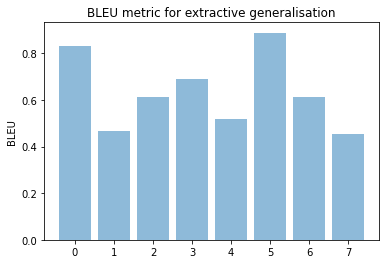

In [133]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.bar(np.arange(len(arr3)), arr3, align='center', alpha=0.5)
plt.title('BLEU metric for extractive generalisation')
plt.ylabel('BLEU')
fig.savefig('bleu.png')
plt.show()